# Titanic survived prediction (Top 10%)
In this tutorial we follow a standard data science pipeline: explore and visualization, feature generation, preproessing and fit models. The enssential goal is to gain familiarity with this pipeline and form my own analysis style.

Here is my kaggle profile: https://www.kaggle.com/haoc04

In [37]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import seaborn as sns
import pickle

import sklearn_pandas
from sklearn_pandas import DataFrameMapper
import sklearn
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
sns.set(
    style="whitegrid",
    rc={'figure.figsize':(10,4)}
)

In [38]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# combine train and test data set
full = train.append(test, ignore_index=True)

## EDA
Explore data set has some essential thing we should bear in mind:
* first, sketch a ER diagram to clarify relations bewteen informations and check hypothesis such as Primary key, one-to-many relations, etc.
* second, ask myself what is one observation unit, here the answer is each passenger, which is obvious.
* third, having the target variable in mind, here we ask what information is related to Survived.

In this tutorial we focus on the third, since data set is simple. We plot the relation of variable with Survived. categorical first, then continuous ones.

See Survival for different categories.

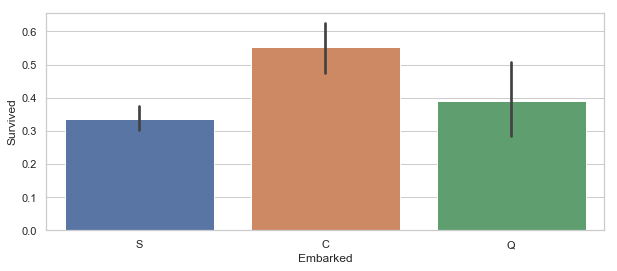

In [39]:
sns.barplot(x='Embarked', y='Survived', data=train)

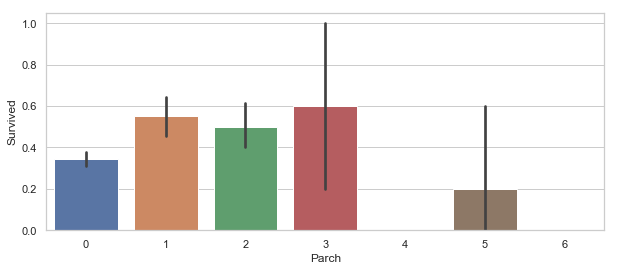

In [40]:

sns.barplot(x='Parch', y='Survived', data=train)

In [41]:
# defiMap = {i:cate for i, cate in zip(full['Parch'].unique(), ['medium', 'large', 'large', 'large', 'small', 'small', 'small'])}
# full['ParchCate'] = full['Parch'].map

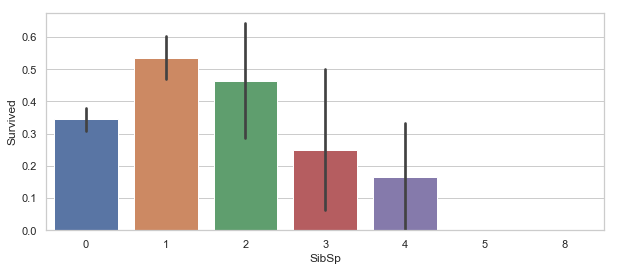

In [42]:
sns.barplot(x='SibSp', y='Survived', data=train)


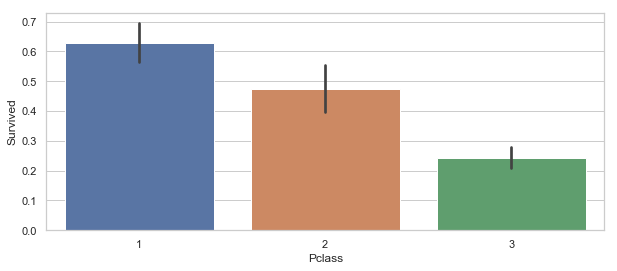

In [43]:
sns.barplot(x='Pclass', y='Survived', data=train)

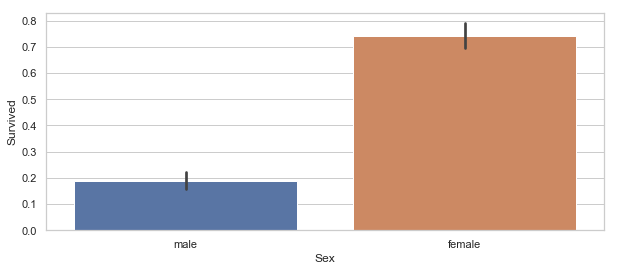

In [44]:
sns.barplot(x='Sex', y='Survived', data=train)

Summary: For these categorical variables, they often has no linear relationship with "survived", except for "Pclass", lower Pclass tends to have lower Survived counts.

The lesson here is, Label encoding for them may not be suitable, but one-hot encoding can extract this nonlinear relationship.

Now we focus on the continuous vaiables.

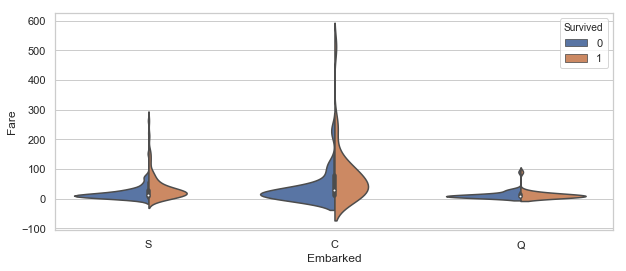

In [102]:
sns.violinplot(x = 'Embarked', y = 'Fare', hue = 'Survived', data = train, split = True)

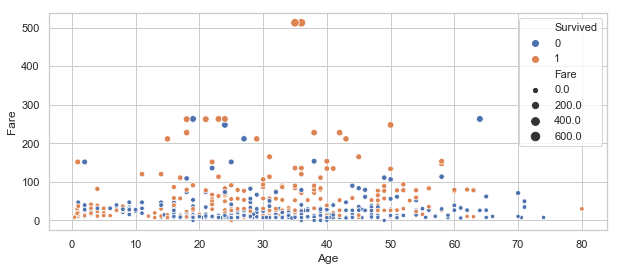

In [103]:
ax = sns.scatterplot(train['Age'], train['Fare'], 
                      hue = train['Survived'], size = train['Fare'])

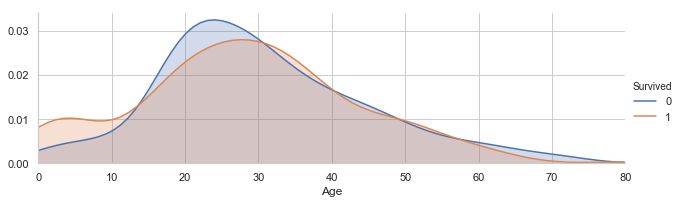

In [45]:
ageFacet = sns.FacetGrid(train, hue='Survived', aspect=3)
ageFacet.map(sns.kdeplot, 'Age', shade=True)
ageFacet.set(xlim=[0, train['Age'].max()])
ageFacet.add_legend()

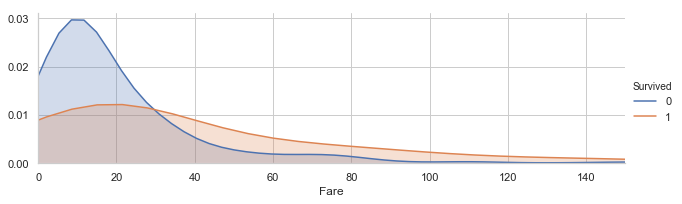

In [46]:
fareFacet = sns.FacetGrid(train, hue='Survived', aspect=3)
fareFacet.map(sns.kdeplot, 'Fare', shade=True)
fareFacet.set(xlim=[0, 150])
fareFacet.add_legend()

Different distributions for the Survived and the nonSurvived. 
* Young people whose age below 10 have more chance to survive(notice the peak at age = 4)
* Low fare people, especially for those less than 25, tends not to survive, but high fare people tends to survive. This finding is coherent with Pclass.


## Generate features
* In Name column, we can extract her or his family name and title,
* In Ticket column, Ticket prefix can categorize data into different groups,
* In canbin column, again we extract cabin prefix.

we parse string by regular expression.

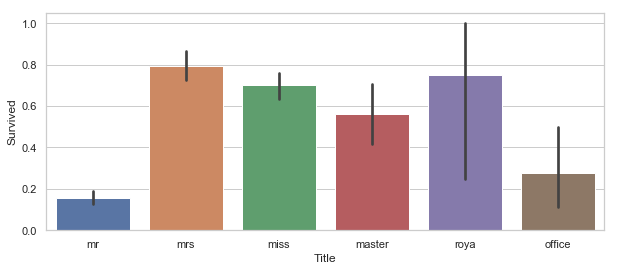

In [47]:
import re

# name 
pattern = re.compile("([^,]+), ([A-Za-z ]+)\.")
full['Title'] = full['Name'].apply(lambda x: pattern.match(x).group(2) if pattern.match(x) is not None else np.nan)

compressed = {}
roya = ['Don', 'Sir', 'Dona', 'Lady', 'the Countess']
master = ['Master', 'Jonkheer']
miss = ['Miss', 'Mlle']
mrs = ['Mrs', 'Mme', 'Ms']
office = ['Capt', 'Major', 'Col', 'Rev', 'Dr']
mr = ['Mr']

for i in roya+master+miss+mrs+office+mr:
    if i in roya:
        compressed[i] = 'roya'
    if i in master:
        compressed[i] = 'master'
    if i in miss:
        compressed[i] = 'miss'
    if i in mrs:
        compressed[i] = 'mrs'
    if i in office:
        compressed[i] = 'office'
compressed['Mr'] = 'mr'

full['Title'] = full['Title'].map(compressed)

sns.barplot(x='Title', y='Survived', data=full)

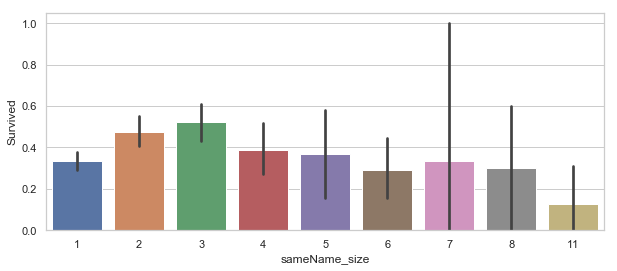

In [48]:
pattern = re.compile("([^,]+), ([A-Za-z ]+)\.")

full['family_name'] = full['Name'].apply(lambda x: pattern.match(x).group(1) if pattern.match(x) is not None else np.nan)
full['sameName_size'] = full['family_name'].map(full['family_name'].value_counts())

sns.barplot(x='sameName_size', y='Survived', data=full)

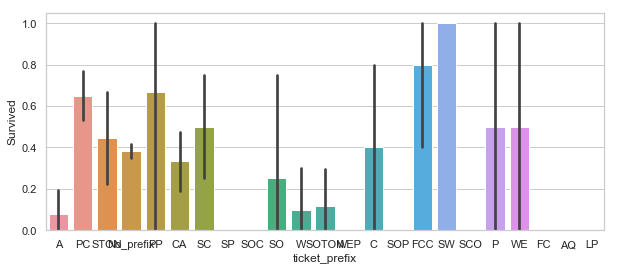

In [49]:
# ticket

pattern = re.compile("([A-Z]+)(/| +).+")
full['Ticket'] = full["Ticket"].apply(lambda x: x.replace('.', ''))
full['ticket_prefix'] = full['Ticket'].apply(lambda x: pattern.match(x).group(1) if pattern.match(x) is not None else 'No_prefix')

sns.barplot(x='ticket_prefix', y='Survived', data=full)


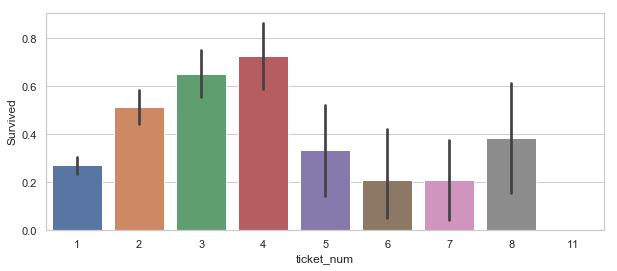

In [50]:
full['ticket_num'] = full['Ticket'].map(full['Ticket'].value_counts())
sns.barplot(x='ticket_num', y='Survived', data=full)

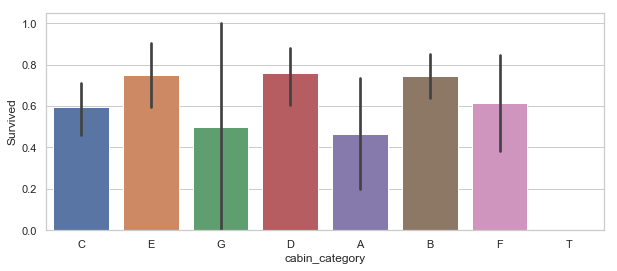

In [51]:
def get_cabin(x):
    if x is not np.nan:
        all_labels = [i[0] for i in str(x).split(" ")]
        return all_labels[0]
    else:
        return np.nan
    
full['cabin_category'] = full['Cabin'].apply(get_cabin)

sns.barplot(x='cabin_category', y='Survived', data=full)

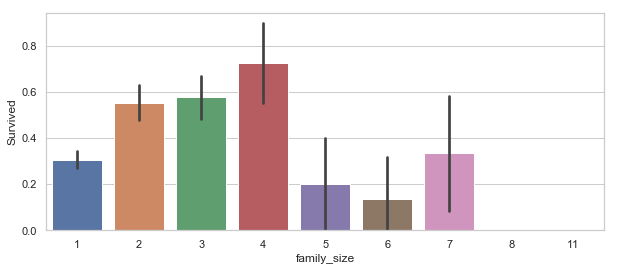

In [52]:
full['family_size'] = full['Parch'] + full['SibSp'] + 1
sns.barplot(x='family_size', y='Survived', data=full)

We extract Title, familyName, shared familyName size, ticketPrefix, shared ticketNumber, cabinCode, which are all categorical and varies substantially with Survived for different groups.

How to use these information: the basic ideal is one-hot encoding, however, after some literature search, I can try the following (not tried in this tutorial):
* aggregate some categories to gain statistical power,
* do PCA transform to compress data (also gain statistical power).
* other feature idea: same family name may has some relations according to Survived.


## Fill na

Now task is to fill na values. We first check na coverage, only Age, Embarked, Cabin and Fare column should be impute nas. We use the following strategy:
* for Fare, fill it with mode of the same group(same Pclass, same Cabin). This is reasonable because these group has similar Fare price. 
* for Embarked, we notice most of people embarked at S, so fill na with S possiably "guessing" right.
* for Cabin, 77% is quite large, we fill with "Unknown" because these people may not have cabin.
* for Age, we select 'Parch', 'Pclass', 'SibSp',  'Title', 'family_size','ticket_num' and train a random forest model to predict missing ages.


In [53]:
def get_naRatio(df):
    """na coverage of DataFrame
    """
    na_df = (df.isnull().sum()/len(df)).reset_index()
    na_df.columns = ['column', 'na_ratio']
    na_df = na_df.sort_values('na_ratio', ascending = False)
    return na_df

get_naRatio(full)

,column,na_ratio
17,cabin_category,0.774637
1,Cabin,0.774637
10,Survived,0.319328
0,Age,0.200917
2,Embarked,0.001528
3,Fare,0.000764
12,Title,0.000000
16,ticket_num,0.000000
15,ticket_prefix,0.000000
14,sameName_size,0.000000


In [54]:
full[full['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,family_name,sameName_size,ticket_prefix,ticket_num,cabin_category,family_size
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,mr,Storey,1,No_prefix,1,NaN,1


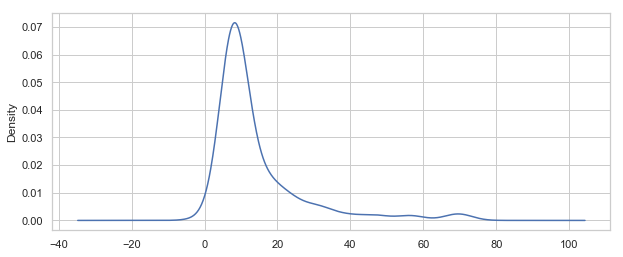

In [55]:
groupFare = full[(full['Embarked'] == 'S') & (full['Pclass'] == 3)]['Fare']
groupFare.plot.kde()
full.loc[1043, 'Fare'] = groupFare.median()

In [56]:
full['Embarked'] = full['Embarked'].fillna('S')
full['cabin_category'] = full['cabin_category'].fillna('Unknown')

In [57]:
import sklearn_pandas
from sklearn_pandas import DataFrameMapper
import sklearn
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler

agePre = full[['Age', 'Parch', 'Pclass', 'SibSp',  'Title', 'sameName_size', 'family_size' ,'ticket_num']]
target = 'Age'
agePre[agePre.columns.difference([target])] = agePre.drop(columns=target).astype('str')
categoryDomain = ['Parch', 'Pclass', 'Title', 'SibSp']
continuousDomain = ['family_size' ,'ticket_num']
mapper = DataFrameMapper([([c], MinMaxScaler()) for c in continuousDomain] +\
                         [([c], LabelBinarizer()) for c in categoryDomain], df_out=True)

In [58]:
agePreTrans = mapper.fit_transform(agePre.drop(columns=target))
agePre = pd.concat([agePre[target], agePreTrans], axis = 1)
agePre.head(2)

,Age,family_size,ticket_num,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,...,Title_mrs,Title_office,Title_roya,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,22.0,0.1,0.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,38.0,0.1,0.1,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [59]:
# select features via correlation
corr_ = agePre.corr()['Age'].abs().sort_values(ascending = False) 
select = corr_[(corr_ > 0.14) | (corr_.isnull())].index
agePre = agePre[select]



In [60]:
agePreNull = agePre[agePre['Age'].isnull()]
agePreTrain = agePre[~agePre['Age'].isnull()]

agePreTrain.shape, agePreNull.shape

((1046, 15), (263, 15))

In [61]:
from sklearn.model_selection import train_test_split

X = agePreTrain.drop(columns='Age')
y = agePreTrain['Age']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state= 27)

In [79]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

clf = RandomForestRegressor(n_estimators=500, max_depth=4)
clf.fit(X_train, y_train)
print('Training score: ', clf.score(X_train, y_train))
print('Validation score: ', clf.score(X_val, y_val))

Training score:  0.4934878902338922
Validation score:  0.4211744276046987


In [63]:
predAge = clf.predict(agePreNull.drop(columns='Age'))
full.loc[agePreNull.index, 'Age'] = predAge.round(0)

In [64]:
full.isnull().sum(axis=0)

Age                  0
Cabin             1014
Embarked             0
Fare                 0
Name                 0
Parch                0
PassengerId          0
Pclass               0
Sex                  0
SibSp                0
Survived           418
Ticket               0
Title                0
family_name          0
sameName_size        0
ticket_prefix        0
ticket_num           0
cabin_category       0
family_size          0
dtype: int64

In [65]:
# save data
def save_to_pickle(object, fname):
    with open(fname, 'wb') as f:
        pickle.dump(object, f)
    return 

save_to_pickle(full, 'full_1025.pkl')


In [66]:
import pickle
def read_pkl(fname):
    with open(fname, 'rb') as f:
        ans = pickle.load(f)
    return ans
full = read_pkl('full_1025.pkl')

## Feature selection
* First we drop PassengerId since it is the key, and also drop Cabin, Name, familyName and Ticket because we will not use them anymore.
* Then we do MinMaxScale for Age and Fare and do One-hot encoding for the remaining coolumns, in the other words we treat them as categorical, for extracting no linear relations as we mentioned early.
* After that we computer correlation with Survived, select features only large than 0.12, of course this is rule of thrumb.

Side note: MinMaxScale here performs substantial better than StandardScale, which need further investigation.

In [67]:
# drop useless columns
full = full.drop(columns = ['PassengerId', 'Cabin', 'Name', 'family_name', 'Ticket'])
full.shape


(1309, 14)

In [68]:
# scale and encoding
target = 'Survived'
continousDomain = ['Age', 'Fare']
categoricalDomain = list(full.columns.difference([target]+continousDomain))

mapper = DataFrameMapper([([c], MinMaxScaler()) for c in continousDomain] +
                        [([c], LabelBinarizer()) for c in categoricalDomain], df_out = True)
ans_df = mapper.fit_transform(full.drop(columns=target))

In [69]:
fullPre = pd.concat([full[target], ans_df], axis=1)
# split train and test set
trainPre = fullPre[~fullPre['Survived'].isnull()]
testPre =  fullPre[fullPre['Survived'].isnull()]
trainPre.shape, testPre.shape

((891, 90), (418, 90))

### PCA visual

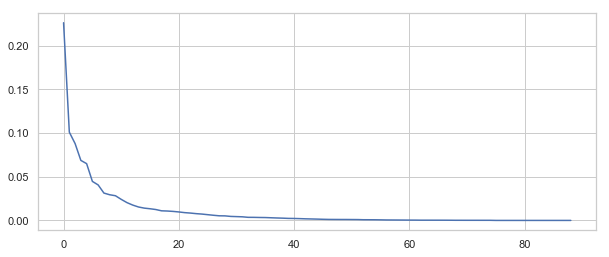

In [70]:
X = fullPre.drop(columns = 'Survived')
y = fullPre['Survived']

from sklearn.decomposition import PCA
pca = PCA()
projection = pca.fit_transform(X)
projection.shape
plt.plot(pca.explained_variance_ratio_)

Using elbow rule, we choose 29 features. Also, I plot first 2 components for visualization.

Text(0.5, 1.0, 'First 2 componement projection')

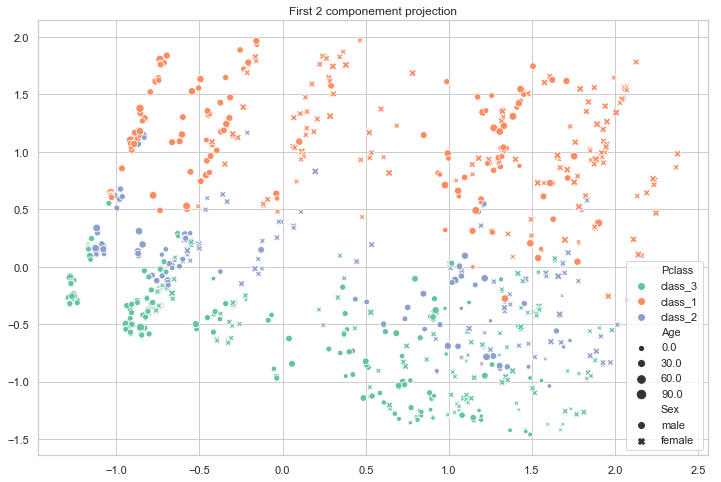

In [101]:
class_cate = full['Pclass'].map({1:'class_1',
                                   2:'class_2',
                                   3:'class_3'})
plt.figure(figsize=(12,8))
ax = sns.scatterplot(projection[:,0], projection[:,1], size = full['Age'], 
                    hue = class_cate, style = full['Sex'], palette='Set2')
fig = ax.figure
ax.set_title('First 2 componement projection')

### correlation select

Text(0.5, 0, 'correlation')

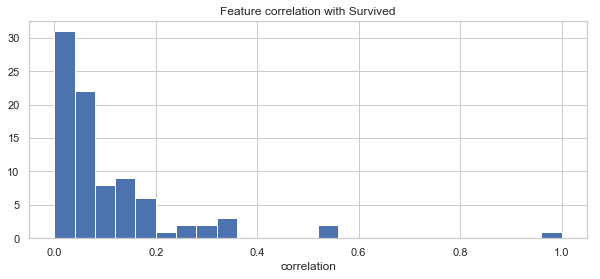

In [72]:
corr = trainPre.corr()[target].abs().sort_values(ascending=False)
ax = corr.hist(bins=25)
ax.set_title('Feature correlation with Survived')
ax.set_xlabel('correlation')

In [73]:
sel_ftrs = corr[(corr.isnull()) | (corr > 0.12)].index
sel_ftrs

Index(['Survived', 'Title_mr', 'Sex', 'Title_mrs', 'Title_miss', 'Pclass_3',
       'cabin_category_Unknown', 'Pclass_1', 'Fare', 'ticket_num_1',
       'family_size_1', 'ticket_num_3', 'cabin_category_B', 'SibSp_1',
       'Embarked_C', 'family_size_2', 'ticket_num_4', 'cabin_category_D',
       'Embarked_S', 'Parch_0', 'ticket_prefix_PC', 'cabin_category_E',
       'family_size_3', 'ticket_num_2', 'Parch_1', 'family_size_4', 'Parch_9',
       'ticket_prefix_AQ', 'ticket_prefix_LP'],
      dtype='object')

In [74]:
# select data set from these selected features
y = trainPre[target]
trainPre = trainPre[sel_ftrs].drop(columns = target)
testPre = testPre[sel_ftrs]

## Fit model
Finally I choose gradient boosting tree in sklearn and do grid search for parameter tuning. I have tried other model and stacking, but there is no minor improvement.

In [85]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split

random_state = 27
Kfold = StratifiedKFold(n_splits=5, random_state = random_state)

In [86]:
X_train, X_val, y_train, y_val = train_test_split(trainPre, y, test_size = 0.2, random_state = random_state)

In [89]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=Kfold, 
                                     scoring="accuracy", verbose = 1, n_jobs=-1)
modelgsGBC.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

Text(0, 0.5, 'accuracy')

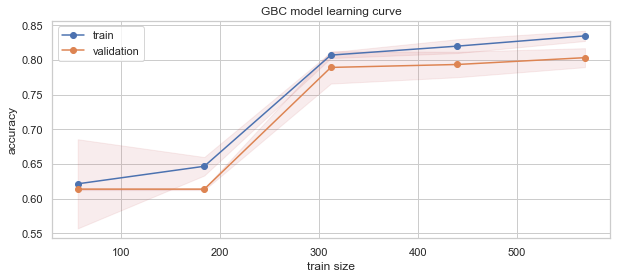

In [95]:
from sklearn.model_selection import learning_curve
train_size, train_score, val_score = learning_curve(modelgsGBC.best_estimator_, X_train, y_train, scoring = 'accuracy', cv =  Kfold, n_jobs = -1)

train_sc_mean = train_score.mean(axis=1)
val_sc_mean = val_score.mean(axis=1)
train_sc_std = train_score.std(axis=1)
val_sc_std = val_score.std(axis=1)

plt.plot(train_size, train_sc_mean, 'o-')
plt.fill_between(train_size, train_sc_mean - train_sc_std, train_sc_mean + train_sc_std, color = 'r', alpha = 0.1)
plt.plot(train_size, val_sc_mean, 'o-')
plt.fill_between(train_size, val_sc_mean - val_sc_std, val_sc_mean + val_sc_std, color = 'r', alpha = 0.1)

plt.legend(['train', 'validation'])
plt.title('GBC model learning curve')
plt.xlabel('train size')
plt.ylabel('accuracy')

Not much overfitting after we do grid search.

In [76]:
trSc, valSc = modelgsGBC.score(X_train,y_train), modelgsGBC.score(X_val,y_val)
print('training score is {}, test score is {}'.format(trSc, valSc))

training score is 0.851123595505618, test score is 0.8715083798882681


In [27]:
# train for the whole available data set

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=Kfold, 
                                     scoring="accuracy", verbose = 1, n_jobs=-1)
modelgsGBC.fit(trainPre, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   20.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [159]:
# predict for test set
X_test = testPre.drop(columns = 'Survived')
y_pred = modelgsGBC.predict(X_test)

# form submit file
submission = pd.read_csv('gender_submission.csv')
ans = pd.DataFrame(np.vstack([test['PassengerId'].values, y_pred]).T, columns = submission.columns).astype('int64')
ans.to_csv('sub_reportwhy.csv', index=False)

# The end
Side notes: 
* Consider accuracy we should be careful to impute missing values (not just fill with 0),
* Consider robustness, outliers are important (not appeared here)
* Some improvement of prediction are just trial and error, for example the problem to choose which scaler. Does this mathematically trackable, if not , should we pay huge attention on that during daily data work (I mean, try a lot).
* Model tuning and split test set is important, because overfitting always happens since we use complex model such as boosting trees. But should not pay over attention to score, say, 0.831 is strictly better than 0.827 beacause there may be some random noise in the fitting process.

Some more question associated:
* Does PCA visualization helpful
* Does aggregate categorical variables helpful
* Does shared Name helpful